In [ ]:
import pandas as pd
import numpy as np
import os

# --- PATHS ---
TEST_DATA_PATH = r"D:\RideWise-Predicting-Bike-sharing-Demand\Data\day(new).csv"
SAVE_MODEL_DIR = r"D:\RideWise-Predicting-Bike-sharing-Demand\Modeling\Saved_Models_files"
SCALER_PATH = os.path.join(SAVE_MODEL_DIR, "scaler.pkl")

# --- 1. Load and preprocess test set as before ---
df = pd.read_csv(TEST_DATA_PATH)
columns_to_drop = ['instant', 'casual', 'registered', 'dteday', 'atemp']
df = df.drop(columns=columns_to_drop)
df['weekend'] = ((df['weekday'] == 0) | (df['weekday'] == 6)).astype(int)
    
dependent_variable = 'cnt'
independent_variables = [col for col in df.columns if col != dependent_variable]
actual_cnt = df[dependent_variable].values


In [2]:
df.info()
df[independent_variables].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  cnt         730 non-null    int64  
 11  weekend     730 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 68.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 

In [3]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,weekend
0,1,0,1,0,6,0,2,14.110847,80.5833,10.749882,985,1
1,1,0,1,0,0,0,2,14.902598,69.6087,16.652113,801,1
2,1,0,1,0,1,1,1,8.050924,43.7273,16.636703,1349,0
3,1,0,1,0,2,1,1,8.200000,59.0435,10.739832,1562,0
4,1,0,1,0,3,1,1,9.305237,43.6957,12.522300,1600,0


In [4]:
import numpy as np
import pandas as pd
import joblib

# Assume df is your *full* test dataframe, not just a sample

# Prepare test features and target
actual_cnt = df[dependent_variable].values
X_full = df[independent_variables]

# Scale all features
with open(SCALER_PATH, 'rb') as f:
  scaler = joblib.load(SCALER_PATH)

scaled_arr = scaler.transform(X_full)
X_full_scaled = pd.DataFrame(scaled_arr, columns=X_full.columns)


# Load all models
model_files = [f for f in os.listdir(SAVE_MODEL_DIR) if f.endswith('.pkl') and f != "scaler.pkl"]
models = {file.replace('.pkl', ''): joblib.load(os.path.join(SAVE_MODEL_DIR, file)) for file in model_files}

# Predict on full dataset!

def smart_predict(model, X_df):
    model_type = str(type(model))

    # Models trained WITHOUT feature names → require numpy input
    if any(key in model_type for key in ["ElasticNet", "Lasso", "Ridge"]):
        X_input = X_df.values  # numpy array
    else:
        # Tree-based models were trained WITH feature names
        X_input = X_df          # DataFrame with column names

    return model.predict(X_input)

output_df_full = pd.DataFrame({'Actual_cnt': actual_cnt})

for name, model in models.items():
        y_pred_raw = smart_predict(model, X_full_scaled)
        y_pred_cnt = np.round(y_pred_raw**2, 0)   # inverse sqrt transform
        output_df_full[f"{name}_Pred"] = y_pred_cnt

# Now sample 10 random rows to display
np.random.seed(42)  # For reproducibility
sample_idx = np.random.choice(output_df_full.index, 10, replace=False)
output_df = output_df_full.loc[sample_idx].reset_index(drop=True)
print(output_df)


   Actual_cnt  decision_tree(CV)_Pred  decision_tree_Pred  \
0        7460                  4595.0              4359.0   
1        4788                  1115.0              2395.0   
2        3331                  1115.0              2395.0   
3        3068                  1115.0              2395.0   
4        7338                  4595.0              4359.0   
5        5423                  1115.0              2395.0   
6        2046                  1115.0              2395.0   
7        2121                  1115.0              2395.0   
8        3409                  1115.0              2395.0   
9        3620                  1115.0              2395.0   

   elastic_net_model(CV)_Pred  elastic_net_model_Pred  final_model_Pred  \
0                     13998.0                  4337.0            4359.0   
1                      2564.0                   995.0            2395.0   
2                     86839.0                133721.0            2395.0   
3                      2636.

d:\RideWise-Predicting-Bike-sharing-Demand\env\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
d:\RideWise-Predicting-Bike-sharing-Demand\env\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
d:\RideWise-Predicting-Bike-sharing-Demand\env\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [5]:
from sklearn.metrics import mean_absolute_error
import joblib

# Dictionary to hold MAEs for each model
mae_scores = {}

# Loop over each model prediction column
for name in models:
    pred_col = f"{name}_Pred"
    # Calculate MAE
    mae = mean_absolute_error(output_df["Actual_cnt"], output_df[pred_col])
    mae_scores[name] = mae
    print(f"{name}: MAE = {mae:.2f}")

# Find the Accurate model (lowest MAE)
Final_model_name= min(mae_scores, key=mae_scores.get)
print(f"\nFinal model: {Final_model_name} (MAE={mae_scores[Final_model_name]:.2f})")

# Save the best model for deployment
Final_model = models[Final_model_name]
Final_model_path = os.path.join(SAVE_MODEL_DIR, "final_model.pkl")
joblib.dump(Final_model, Final_model_path)
print(f"Final model saved to: {Final_model_path}")


decision_tree(CV): MAE = 2449.40
decision_tree: MAE = 1597.20
elastic_net_model(CV): MAE = 70758.20
elastic_net_model: MAE = 93655.10
final_model: MAE = 1597.20
gradient_boost(CV): MAE = 2518.40
gradient_boost: MAE = 3132.80
lasso_model(CV): MAE = 72805.90
lasso_model: MAE = 79672.50
randomforest: MAE = 1634.20
random_forest(CV): MAE = 1642.10
ridge_model(CV): MAE = 72805.90
ridge_model: MAE = 93496.50

Final model: decision_tree (MAE=1597.20)
Final model saved to: D:\RideWise-Predicting-Bike-sharing-Demand\Modeling\Saved_Models_files\final_model.pkl


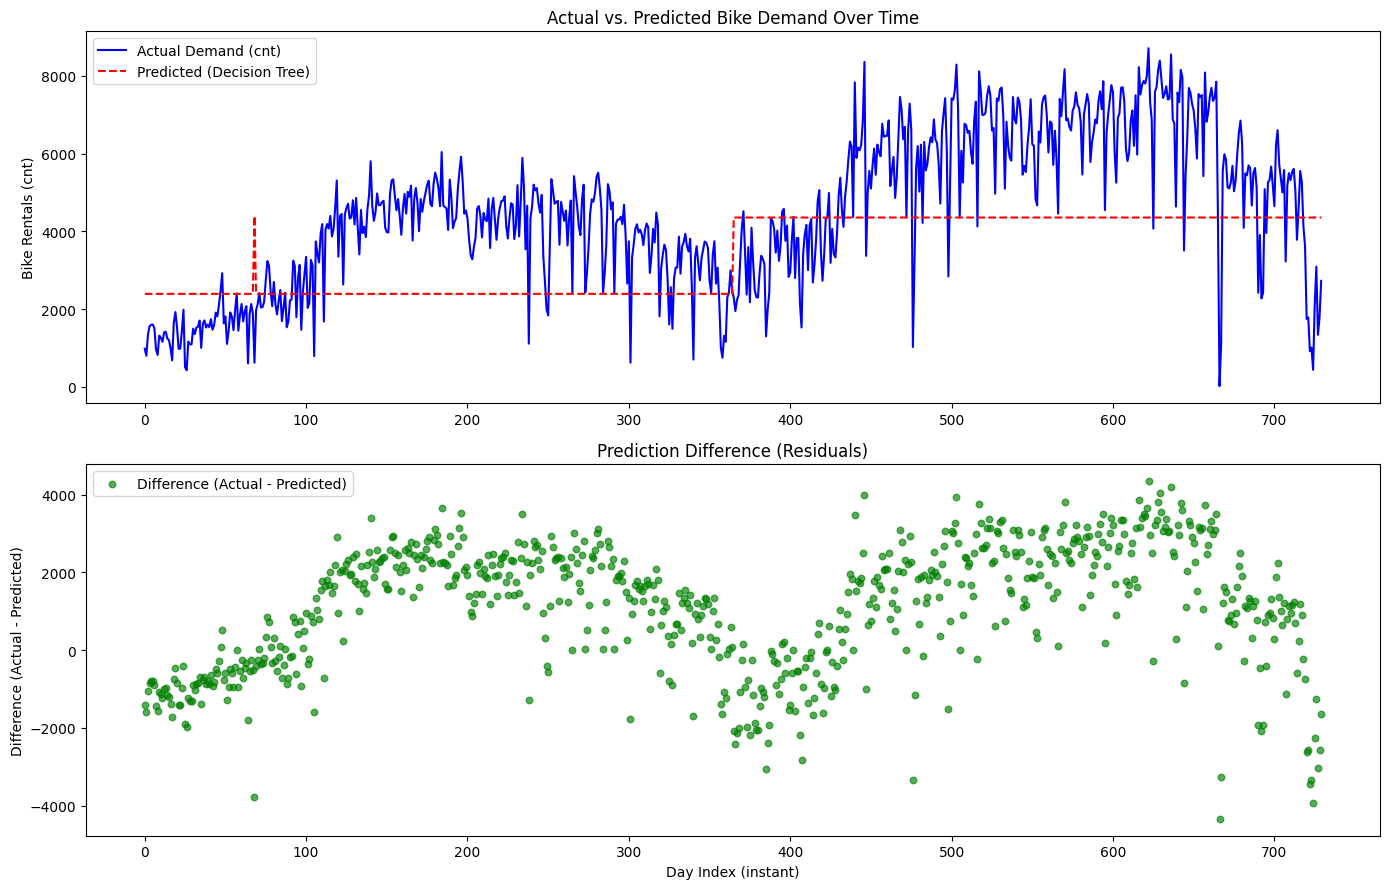

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on full dataset as above; assume output_df_full as below:
# output_df_full = pd.DataFrame({'Actual_cnt': actual_cnt, ...model predictions...})

# For Decision Tree model, get predictions:
decisiontree_pred = output_df_full['decision_tree_Pred'].values
actual_cnt = output_df_full['Actual_cnt'].values

# If you have 'instant' or date column in your original df, use it:
if 'instant' in df.columns:
    x_axis = df['instant'].values
else:
    x_axis = np.arange(len(actual_cnt))

# --- Top Plot: Actual vs. Predicted Demand Over Time ---
plt.figure(figsize=(14, 9))

plt.subplot(2, 1, 1)
plt.plot(x_axis, actual_cnt, label='Actual Demand (cnt)', color='blue')
plt.plot(x_axis, decisiontree_pred, label='Predicted (Decision Tree)', color='red', linestyle='--')
plt.ylabel('Bike Rentals (cnt)')
plt.title('Actual vs. Predicted Bike Demand Over Time')
plt.legend()

# --- Bottom Plot: Residuals Over Time ---
residuals = actual_cnt - decisiontree_pred

plt.subplot(2, 1, 2)
plt.scatter(x_axis, residuals, color='green', alpha=0.65, s=22, label='Difference (Actual - Predicted)')
plt.xlabel('Day Index (instant)')
plt.ylabel('Difference (Actual - Predicted)')
plt.title('Prediction Difference (Residuals)')
plt.legend()

plt.tight_layout()
plt.show()


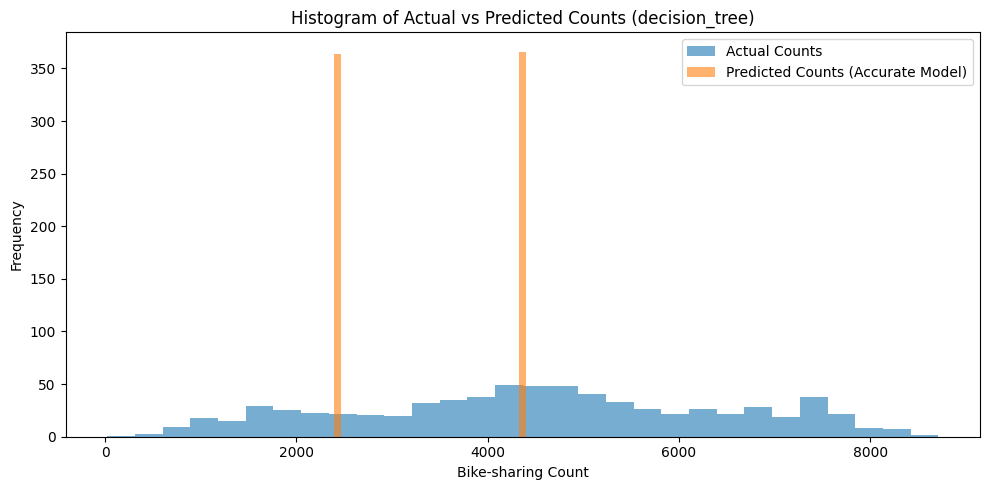

d:\RideWise-Predicting-Bike-sharing-Demand\env\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
d:\RideWise-Predicting-Bike-sharing-Demand\env\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
d:\RideWise-Predicting-Bike-sharing-Demand\env\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
d:\RideWise-Predicting-Bike-sharing-Demand\env\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
d:\RideWise-Predicting-Bike-sharing-Demand\env\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
d:\RideWise-Predicting-Bi

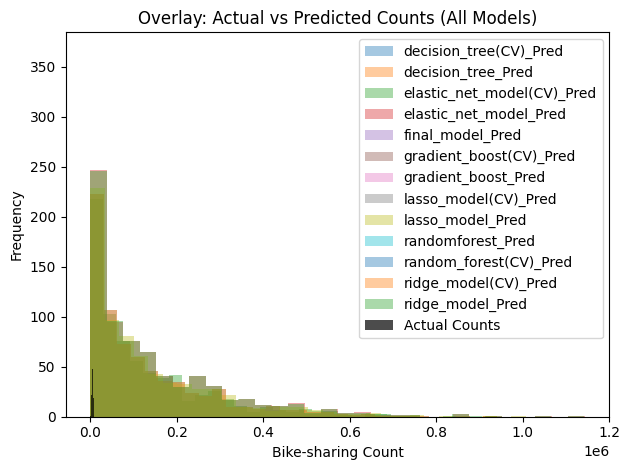

In [7]:
import matplotlib.pyplot as plt

# --- Histogram: Actual vs Predicted for best model ---
plt.figure(figsize=(10, 5))

plt.hist(output_df_full['Actual_cnt'].values, bins=30, alpha=0.6, label='Actual Counts')
plt.hist(output_df_full[f"{Final_model_name}_Pred"].values, bins=30, alpha=0.6, label='Predicted Counts (Accurate Model)')
plt.title(f'Histogram of Actual vs Predicted Counts ({Final_model_name})')
plt.xlabel('Bike-sharing Count')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# --- Overlay predictions from other models (optional) ---
for name in models:  # Loop through all models you loaded
    y_pred = np.round(models[name].predict(X_full_scaled)**2, 0)
    plt.hist(y_pred, bins=30, alpha=0.4, label=f'{name}_Pred')

plt.hist(output_df_full['Actual_cnt'].values, bins=30, alpha=0.7, label='Actual Counts', color='black')
plt.title('Overlay: Actual vs Predicted Counts (All Models)')
plt.xlabel('Bike-sharing Count')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


In [1]:
pip install streamlit

  Using cached streamlit-1.51.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached altair-5.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached cachetools-6.2.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached protobuf-6.33.1-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached pyarrow-21.0.0-cp313-cp313-win_amd64.whl.metadata (3.4 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached watchdog-6.0.0-py3-none-win_amd64.whl.metadata (44 kB)
  Using cached gitpython-3.1.45-py3-none-any.whl.metadata (13 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadat


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
